The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST.

The digits have been size-normalized and centered in a fixed-size image.

http://yann.lecun.com/exdb/mnist/

In [0]:
# !wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz #train images
# !wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz #train labels
# !wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz #test images
# !wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz #test labels

In [2]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [3]:
!pip install idx2numpy

In [4]:
import gzip, idx2numpy
import numpy as np

images_archive = gzip.open('train-images-idx3-ubyte.gz', 'r')
labels_archive = gzip.open('train-labels-idx1-ubyte.gz', 'r')
test_img_archive = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
test_lbl_archive = gzip.open('t10k-labels-idx1-ubyte.gz', 'r')

images = idx2numpy.convert_from_file(images_archive)
labels = idx2numpy.convert_from_file(labels_archive)
test_images = idx2numpy.convert_from_file(test_img_archive)
test_labels = idx2numpy.convert_from_file(test_lbl_archive)

images.shape, labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

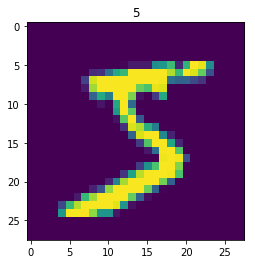

In [5]:
import matplotlib.pyplot as plt

def plot_img(image, label):
  plt.imshow(image)
  plt.title(label)
  plt.show()

plot_img(images[0], labels[0])

In [6]:
#splitting the data 80-20
X_train = images[:48000]
Y_train = labels[:48000]
X_val = images[48000:]
Y_val = labels[48000:]

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class ImagesDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, i):
    return (self.X[i], self.Y[i])

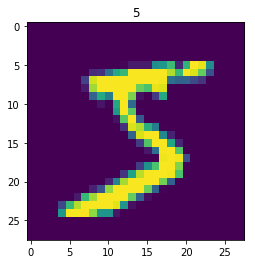

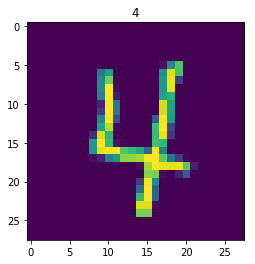

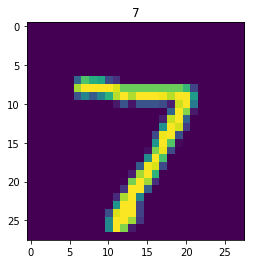

(48000, 12000, 10000)

In [9]:
train = ImagesDataset(X_train, Y_train)
val = ImagesDataset(X_val, Y_val)
test = ImagesDataset(test_images, test_labels)

#sanity check
image_tr, label_tr = train[0]
image_v, label_v = val[0]
image_t, label_t = test[0]
plot_img(image_tr, label_tr), plot_img(image_v, label_v), plot_img(image_t, label_t)
len(train), len(val), len(test)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [0]:
class Perceptron(nn.Module):
  def __init__(self):
    super(Perceptron, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.l2 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.l1(x))
    x = self.l2(x)
    return F.log_softmax(x, dim=-1)

In [0]:
device = 'cuda'

train_loader = DataLoader(train, batch_size=256, shuffle=True)
eval_loader = DataLoader(val, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256)

model = Perceptron()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
cel = nn.CrossEntropyLoss()

if device == 'cuda':
  model.cuda()

In [0]:
def fit(epochs, lr):
  optimizer.param_groups[0]['lr'] = lr

  for epoch in range(1, epochs+1):
    val_loss = 0

    #train loop
    model.train()
    for batch_index, (x, y) in enumerate(train_loader):
      x, y = x.float().to(device), y.long().to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = cel(pred, y)
      loss.backward()
      optimizer.step()

    #val loop
    model.eval()
    for batch_index, (x, y) in enumerate(eval_loader):
      x, y = x.float().to(device), y.long().to(device)
      pred = model(x)
      val_loss += cel(pred, y)
    
    val_loss /= len(eval_loader.dataset)
    print(f'epoch: {epoch};  loss:{round(loss.item(), 4)}\t val_loss: {val_loss}')

In [14]:
fit(20, 1e-4)

epoch: 1;  loss:1.519	 val_loss: 0.00367001723498106
epoch: 2;  loss:0.4735	 val_loss: 0.002418670104816556
epoch: 3;  loss:0.364	 val_loss: 0.002012485871091485
epoch: 4;  loss:0.4464	 val_loss: 0.0016612706240266562
epoch: 5;  loss:0.2188	 val_loss: 0.0014832076849415898
epoch: 6;  loss:0.2378	 val_loss: 0.0013677641982212663
epoch: 7;  loss:0.3206	 val_loss: 0.0012829635525122285
epoch: 8;  loss:0.1294	 val_loss: 0.0011960661504417658
epoch: 9;  loss:0.0957	 val_loss: 0.0010984590044245124
epoch: 10;  loss:0.0818	 val_loss: 0.0010549334110692143
epoch: 11;  loss:0.0331	 val_loss: 0.00109203124884516
epoch: 12;  loss:0.0936	 val_loss: 0.0010242668213322759
epoch: 13;  loss:0.023	 val_loss: 0.0009749812306836247
epoch: 14;  loss:0.1091	 val_loss: 0.0009910969529300928
epoch: 15;  loss:0.0136	 val_loss: 0.0009686166886240244
epoch: 16;  loss:0.0063	 val_loss: 0.0009504752233624458
epoch: 17;  loss:0.0041	 val_loss: 0.0009413888910785317
epoch: 18;  loss:0.0167	 val_loss: 0.000925706641

In [15]:
fit(20, 1e-6)

epoch: 1;  loss:0.0143	 val_loss: 0.000926080800127238
epoch: 2;  loss:0.0043	 val_loss: 0.000920158694498241
epoch: 3;  loss:0.0049	 val_loss: 0.0009189266129396856
epoch: 4;  loss:0.0024	 val_loss: 0.000921910279430449
epoch: 5;  loss:0.004	 val_loss: 0.0009173461585305631
epoch: 6;  loss:0.0117	 val_loss: 0.0009156136657111347
epoch: 7;  loss:0.0044	 val_loss: 0.0009147725068032742
epoch: 8;  loss:0.0086	 val_loss: 0.0009139323956333101
epoch: 9;  loss:0.0033	 val_loss: 0.0009149201796390116
epoch: 10;  loss:0.0281	 val_loss: 0.0009127190569415689
epoch: 11;  loss:0.0079	 val_loss: 0.0009130609687417746
epoch: 12;  loss:0.0149	 val_loss: 0.0009145071962848306
epoch: 13;  loss:0.0094	 val_loss: 0.0009145969524979591
epoch: 14;  loss:0.0021	 val_loss: 0.000914936710614711
epoch: 15;  loss:0.0061	 val_loss: 0.0009133730782195926
epoch: 16;  loss:0.0113	 val_loss: 0.0009121760376729071
epoch: 17;  loss:0.007	 val_loss: 0.0009136036969721317
epoch: 18;  loss:0.0057	 val_loss: 0.000912058

In [16]:
def test_model():
  model.eval()
  for batch_index, (x, y) in enumerate(test_loader):
    x, y = x.float().to(device), y.long().to(device)

    pred = model(x)
    pred = torch.argmax(pred, -1)

    #returns the matching values as bool, then sums them: True = 1, False = 0
    #example: [True, False, False] = 1; [True, True, True] = 3
    correct = torch.sum(pred==y) 

    #divide the number of correctly labeled digits by the total number of digits
    #in the batch.
    #example: 98 correctly labeled with batch_size=100 will result in: 98/100 = 0.98
    pct_correct = correct/torch.tensor(test_loader.batch_size, dtype=torch.float32)

    #append the result into the list for later calculations
    if 'errors' in locals():
      torch.stack((errors, pct_correct))
    else:
      errors = pct_correct

  #calculate the mean accuracy
  #example: [0.98, 0.95, 0.90, 0.95].mean() = 0.94
  print(f'Model accuracy: {errors.mean().cpu().numpy()*100}%')

test_model()

Model accuracy: 98.4375%
